<center>

### CS-GY 9223: Intro To Responsible AI

### Fairness Audit of Student Performance Prediction Model
</center>

<center>

Laxman Singh Rawat      |       Nikhil Mahana       |       Yathin Reddy Duvuru

</center>

## Background

#### Dataset Overview

This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por).

The dataset contains information on students’ demographic and academic attributes such as:
- Parental education levels (`Medu`, `Fedu`)  
- Study and travel times (`studytime`, `traveltime`)  
- Family and social relationships (`famrel`, `goout`, `romantic`)  
- Academic performance indicators (`G1`, `G2`, `failures`)  
- Lifestyle factors (`Dalc`, `Walc`, `health`, `absences`)

| Attribute | Description | Domain |
|-----------|-------------|---------|
| **sex** | Student's sex | Binary: female or male |
| **age** | Student's age | Numeric: from 15 to 22 |
| **school** | Student's school | Binary: Gabriel Pereira or Mousinho da Silveira |
| **address** | Student's home address type | Binary: urban or rural |
| **Pstatus** | Parent's cohabitation status | Binary: living together or apart |
| **Medu** | Mother's education | Numeric: from 0 to 4ᵃ |
| **Mjob** | Mother's job | Nominalᵇ |
| **Fedu** | Father's education | Numeric: from 0 to 4ᵃ |
| **Fjob** | Father's job | Nominalᵇ |
| **guardian** | Student's guardian | Nominal: mother, father or other |
| **famsize** | Family size | Binary: ≤ 3 or > 3 |
| **famrel** | Quality of family relationships | Numeric: from 1 (very bad) to 5 (excellent) |
| **reason** | Reason to choose this school | Nominal: close to home, school reputation, course preference or other |
| **traveltime** | Home to school travel time | Numeric: 1 (< 15 min.), 2 (15 to 30 min.), 3 (30 min. to 1 hour) or 4 (> 1 hour) |
| **studytime** | Weekly study time | Numeric: 1 (< 2 hours), 2 (2 to 5 hours), 3 (5 to 10 hours) or 4 (> 10 hours) |
| **failures** | Number of past class failures | Numeric: n if 1 ≤ n < 3, else 4 |
| **schoolsup** | Extra educational school support | Binary: yes or no |
| **famsup** | Family educational support | Binary: yes or no |
| **activities** | Extra-curricular activities | Binary: yes or no |
| **paidclass** | Extra paid classes | Binary: yes or no |
| **internet** | Internet access at home | Binary: yes or no |
| **nursery** | Attended nursery school | Binary: yes or no |
| **higher** | Wants to take higher education | Binary: yes or no |
| **romantic** | With a romantic relationship | Binary: yes or no |
| **freetime** | Free time after school | Numeric: from 1 (very low) to 5 (very high) |
| **goout** | Going out with friends | Numeric: from 1 (very low) to 5 (very high) |
| **Walc** | Weekend alcohol consumption | Numeric: from 1 (very low) to 5 (very high) |
| **Dalc** | Workday alcohol consumption | Numeric: from 1 (very low) to 5 (very high) |
| **health** | Current health status | Numeric: from 1 (very bad) to 5 (very good) |
| **absences** | Number of school absences | Numeric: from 0 to 93 |
| **G1** | First period grade | Numeric: from 0 to 20 |
| **G2** | Second period grade | Numeric: from 0 to 20 |
| **G3** | Final grade | Numeric: from 0 to 20 |

**Notes:**
- ᵃ Education levels: 0 (none), 1 (primary education - 4th grade), 2 (5th to 9th grade), 3 (secondary education), 4 (higher education)
- ᵇ Nominal job categories include: teacher, health care related, civil services, at_home, or other

### Data Profiling

#### Import Libraries and Dependencies

In [ ]:
# Data manipulation and numerical computing
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations in Python
import matplotlib.ticker as ticker  # For formatting the ticks on the axes of plots
import seaborn as sn  # For statistical data visualization based on matplotlib
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computing and handling arrays

# Machine learning - model training and evaluation
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler  # For standardizing features by removing the mean and scaling to unit variance
from sklearn.linear_model import LogisticRegression  # For logistic regression modeling
import sklearn.metrics as skm  # For evaluating the performance of machine learning models
from sklearn.model_selection import cross_val_score  # For cross-validation of models

# Fairness evaluation metrics
from fairlearn.metrics import MetricFrame  # For creating a frame of metrics for fairness evaluation
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, selection_rate  # For measuring demographic parity
from fairlearn.metrics import false_negative_rate, false_positive_rate  # For measuring false negative and positive rates

# Data fetching and utilities
from ucimlrepo import fetch_ucirepo  # For accessing datasets from the UCI Machine Learning Repository
from IPython.display import clear_output  # For clearing the output of the current cell

import math

In [20]:
# fetch dataset 
student_performance = fetch_ucirepo(id=320) 
  
# data (as pandas dataframes) 
X = student_performance.data.features 
y = student_performance.data.targets 

full_df = X.join(y, how='outer')
full_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [21]:
full_df.shape

(649, 33)

In [22]:
#@markdown Check missing values and data types
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [23]:
full_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,649.0,16.744222,1.218138,15.0,16.0,17.0,18.0,22.0
Medu,649.0,2.514638,1.134552,0.0,2.0,2.0,4.0,4.0
Fedu,649.0,2.306626,1.099931,0.0,1.0,2.0,3.0,4.0
traveltime,649.0,1.568567,0.748660,1.0,1.0,1.0,2.0,4.0
studytime,649.0,1.930663,0.829510,1.0,1.0,2.0,2.0,4.0
failures,649.0,0.221880,0.593235,0.0,0.0,0.0,0.0,3.0
famrel,649.0,3.930663,0.955717,1.0,4.0,4.0,5.0,5.0
freetime,649.0,3.180277,1.051093,1.0,3.0,3.0,4.0,5.0
goout,649.0,3.184900,1.175766,1.0,2.0,3.0,4.0,5.0
Dalc,649.0,1.502311,0.924834,1.0,1.0,1.0,2.0,5.0


In [24]:
num_cols = full_df.select_dtypes(include='int64').columns
cat_cols = full_df.select_dtypes(include='object').columns
print(f'Numerical columns: {num_cols}')
print(f'Categorical columns: {cat_cols}')

Numerical columns: Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'G3'],
      dtype='object')
Categorical columns: Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object')


In [25]:
edu_map = {
    0: "none",
    1: "primary (4th grade)",
    2: "5th to 9th grade",
    3: "secondary",
    4: "higher education"
}

traveltime_map = {
    1: "<15 min",
    2: "15–30 min",
    3: "30 min–1 hour",
    4: ">1 hour"
}

studytime_map = {
    1: "<2 hours",
    2: "2–5 hours",
    3: "5–10 hours",
    4: ">10 hours"
}

school_map = {
    'GP': 'Gabriel Pereira',
    'MS': 'Mousinho da Silveira'
}

address_map = {
    'U': 'urban',
    'R': 'rural'
}

famsize_map = {
    'GT3': 'greater than 3',
    'LE3': 'less or equal to 3'
}

Pstatus_map = {'T': 'living together',
               'A': 'apart'
}


full_df["Medu"] = full_df["Medu"].map(edu_map)
full_df["Fedu"] = full_df["Fedu"].map(edu_map)
full_df["traveltime"] = full_df["traveltime"].map(traveltime_map)
full_df["studytime"] = full_df["studytime"].map(studytime_map)

full_df['school'] = full_df['school'].map(school_map)
full_df['address'] = full_df['address'].map(address_map)
full_df['famsize'] = full_df['famsize'].map(famsize_map)
full_df['Pstatus'] = full_df['Pstatus'].map(Pstatus_map)

full_df[cat_cols].head()

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,Gabriel Pereira,F,urban,greater than 3,apart,at_home,teacher,course,mother,yes,no,no,no,yes,yes,no,no
1,Gabriel Pereira,F,urban,greater than 3,living together,at_home,other,course,father,no,yes,no,no,no,yes,yes,no
2,Gabriel Pereira,F,urban,less or equal to 3,living together,at_home,other,other,mother,yes,no,no,no,yes,yes,yes,no
3,Gabriel Pereira,F,urban,greater than 3,living together,health,services,home,mother,no,yes,no,yes,yes,yes,yes,yes
4,Gabriel Pereira,F,urban,greater than 3,living together,other,other,home,father,no,yes,no,no,yes,yes,no,no


In [29]:
num_cols = full_df.select_dtypes(include='int64').columns
cat_cols = full_df.select_dtypes(include='object').columns

C:\Users\laxma\AppData\Local\Temp\ipykernel_27312\3228608096.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sn.countplot(data=full_df,
C:\Users\laxma\AppData\Local\Temp\ipykernel_27312\3228608096.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sn.countplot(data=full_df,
C:\Users\laxma\AppData\Local\Temp\ipykernel_27312\3228608096.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sn.countplot(data=full_df,
C:\Users\laxma\AppData\Local\Temp\ipykernel_27312\3228608096.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated an

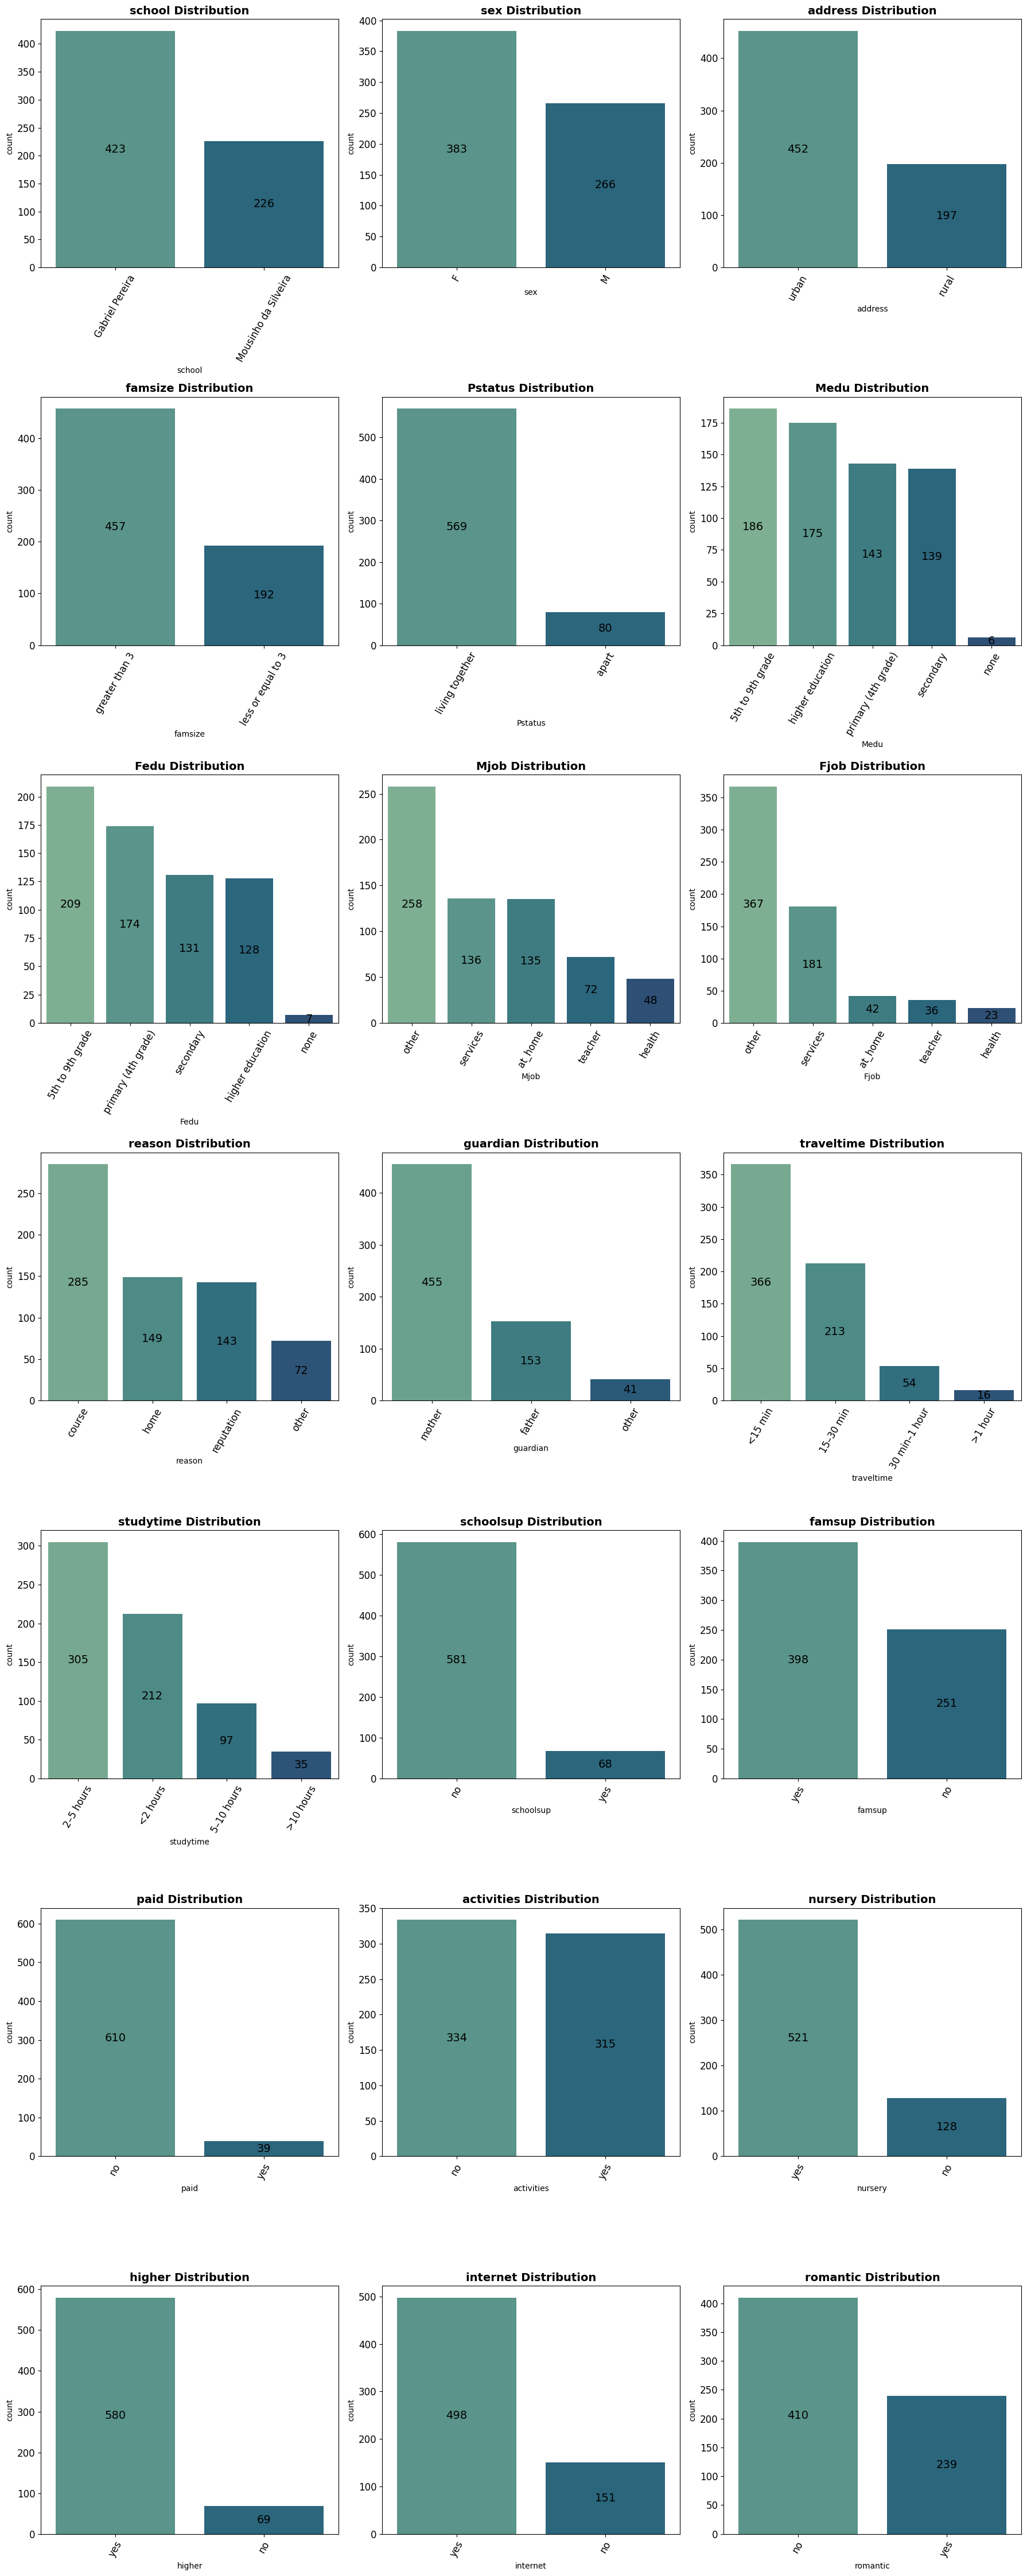

In [30]:
rows, cols = 7, 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 45))
axes = axes.flatten()

# Plot each categorical column
for i, col_name in enumerate(cat_cols):
    ax = axes[i]
    plot = sn.countplot(data=full_df,
                         x=full_df[col_name],
                         ax=ax,
                         palette="crest",
                         order = full_df[col_name].value_counts().index
    )

    # Set titles and font sizes
    ax.set_title(f"{col_name} Distribution", fontsize=14, fontweight='bold')
    ax.tick_params(axis="x", rotation=60, labelsize=12)
    ax.tick_params(axis="y", labelsize=12)

    # Add frequency labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='center', fontsize=14)

# Remove unused axes if cat_cols < rows*cols
for j in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


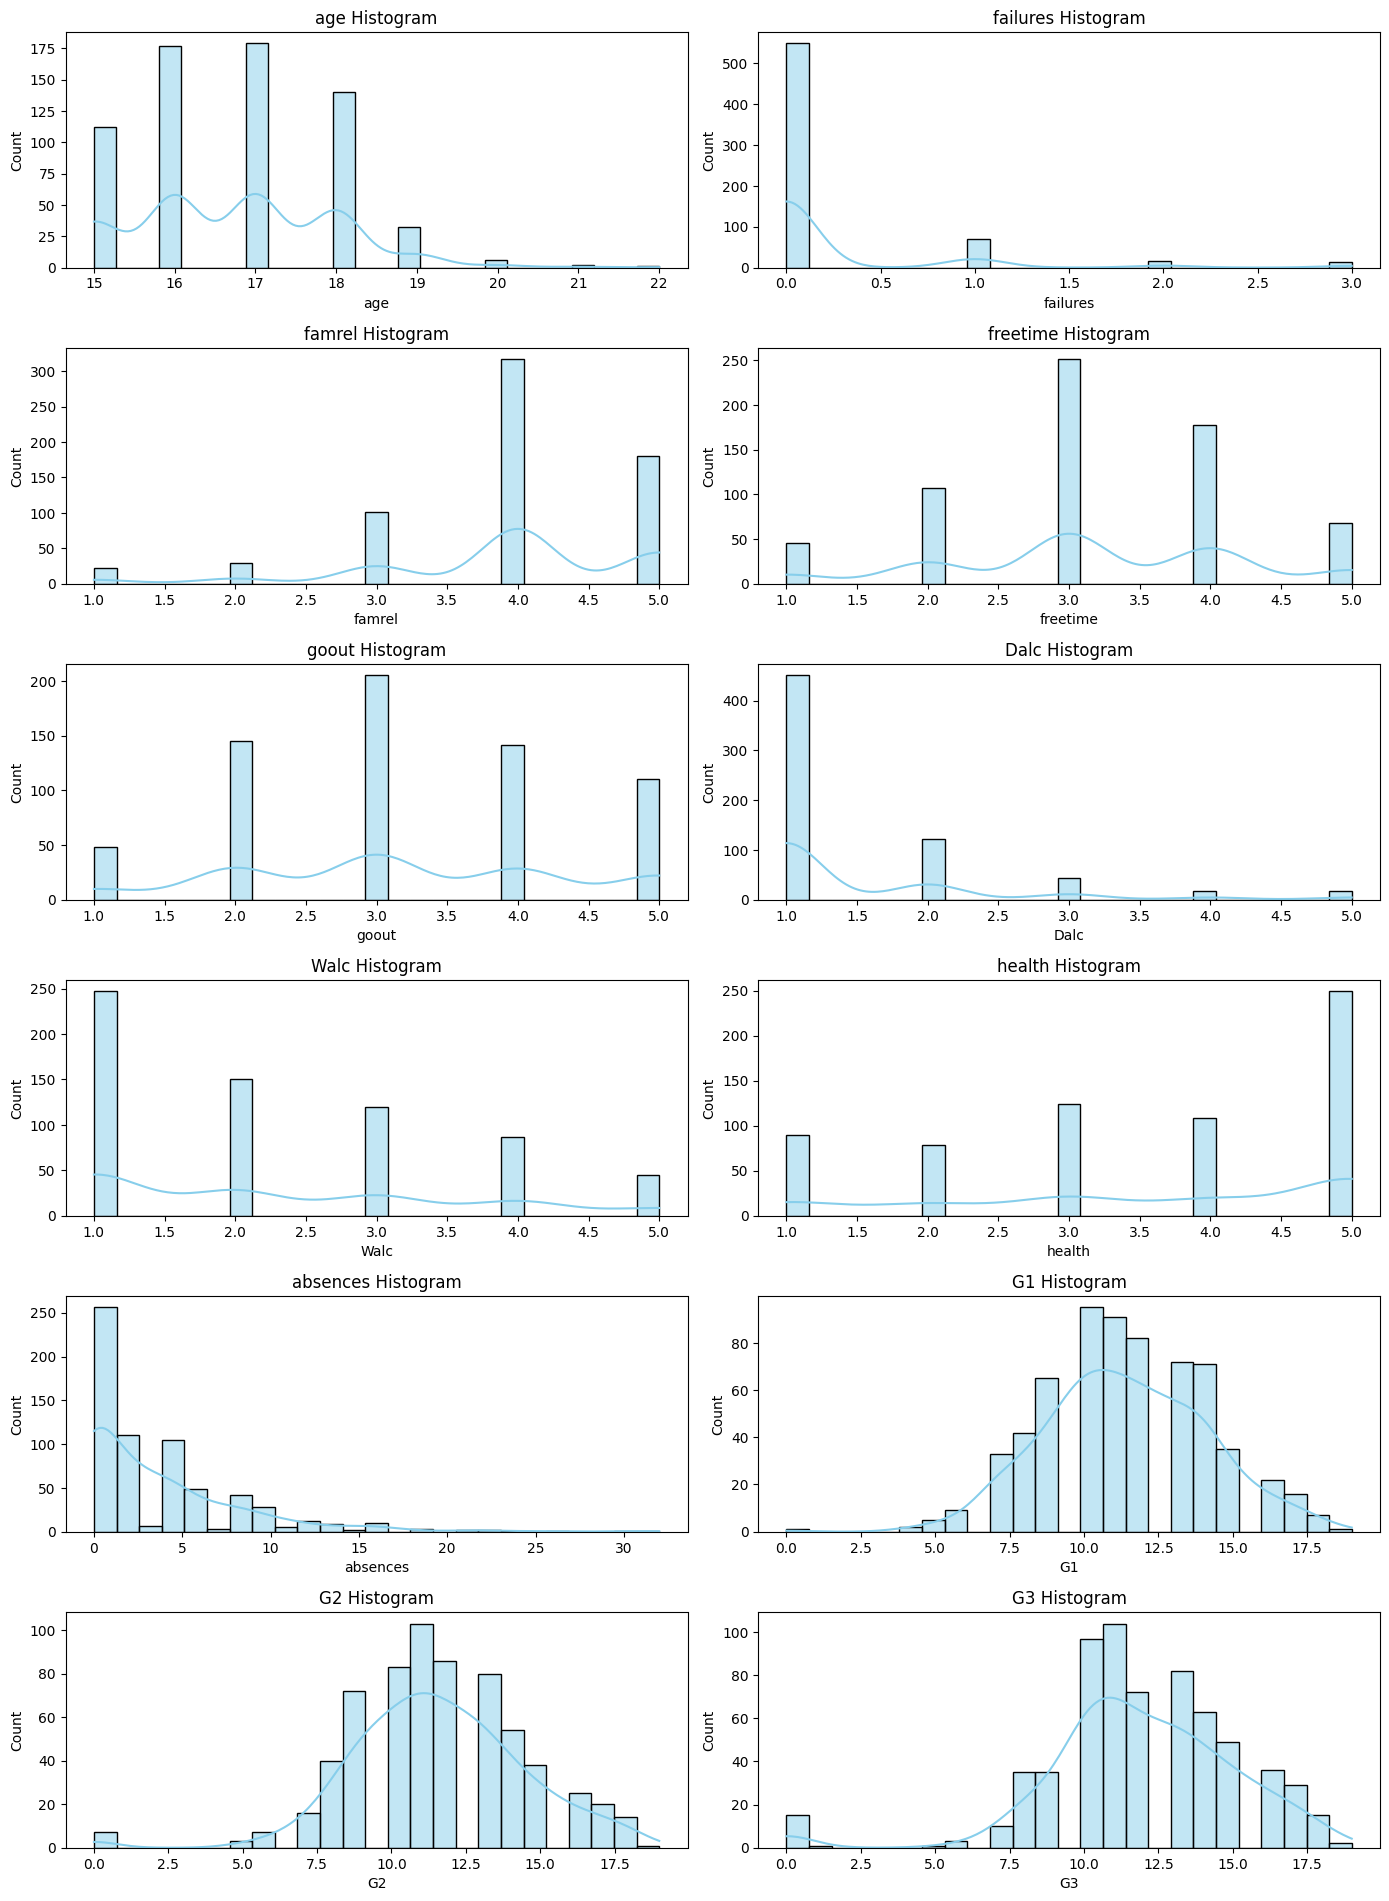

In [31]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(14, 25))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sn.histplot(full_df[col],
                 bins= np.sqrt(len(full_df[col])),
                 kde=True,
                 color="skyblue",
                 ax=axes[i],
                 binwidth= round((full_df[col].max() - full_df[col].min()) / np.sqrt(len(full_df[col])),2)
    )
    axes[i].set_title(f"{col} Histogram", fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

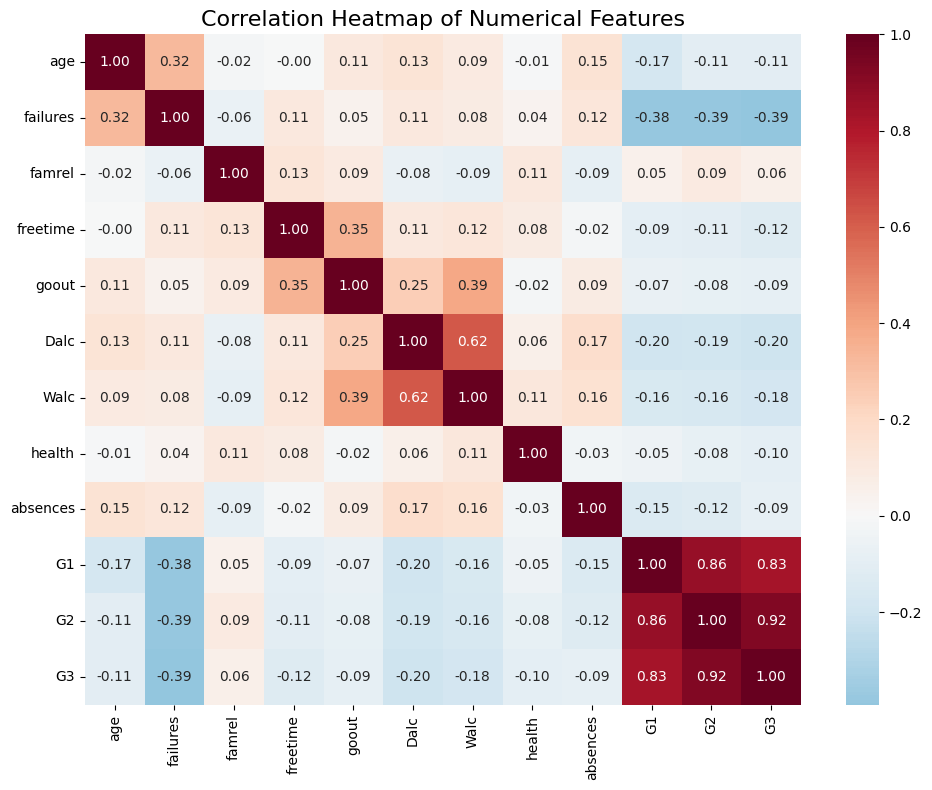

In [32]:
corr = full_df[num_cols].corr()

plt.figure(figsize=(10, 8))
sn.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0, cbar=True)

plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()